In [1]:
import tensorflow
from tensorflow.keras.models import load_model,save_model
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tempfile
import tensorflow_model_optimization as tfmot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Model configuration
img_width, img_height = 300, 300
batch_size = 32
no_epochs = 30
no_classes = 2
verbosity = 1

train_dir = "E://PDuCV//chest_xray//train"
test_dir = "E://PDuCV//chest_xray//test"
val_dir = "E://PDuCV//chest_xray//val"

In [2]:
data_gen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2, 
                             zoom_range = 0.15,
                             rotation_range = 7,
                             width_shift_range=0.15,  
                             height_shift_range=0.1,  
                             horizontal_flip=True)

train_gen = data_gen.flow_from_directory(train_dir,
                                           target_size = (300, 300),
                                           batch_size = 32,
                                           shuffle = True,
                                           color_mode = 'grayscale',
                                            class_mode = 'binary')


val_test_gen = ImageDataGenerator(rescale = 1./255)

val_gen = val_test_gen.flow_from_directory(val_dir,
                                      target_size = (300, 300),
                                      batch_size = 32,
                                      shuffle = False,
                                      color_mode = 'grayscale',
                                      class_mode = 'binary')

test_gen = val_test_gen.flow_from_directory(test_dir,
                                      target_size = (300, 300),
                                      batch_size = 32,
                                      shuffle = False,
                                      color_mode = 'grayscale',
                                      class_mode = 'binary')

Found 4016 images belonging to 2 classes.
Found 1016 images belonging to 2 classes.
Found 824 images belonging to 2 classes.


In [3]:
input_train = train_gen
input_test = test_gen
input_shape = (img_width, img_height, 1)

In [4]:
model = load_model("E:\\PDuCV\\first_model.h5")
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_epochs = 15
num_images = 4016
end_step = np.ceil(num_images / batch_size).astype(np.int32) * pruning_epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.40,
                                                               final_sparsity=0.70,
                                                               begin_step=0,
                                                               end_step=end_step)
}
model_for_pruning = prune_low_magnitude(model, **pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [5]:

model_for_pruning.compile(loss=tensorflow.keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]


model_for_pruning.fit(x= input_train,
                      validation_data = val_gen,
                      epochs=pruning_epochs,
                      verbose=verbosity,
                      callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 126 steps, validate for 32 steps
Epoch 1/15
126/126 [==============================] - 98s 779ms/step - loss: 0.0904 - accuracy: 0.9681 - val_loss: 0.1955 - val_accuracy: 0.9222
Epoch 2/15
126/126 [==============================] - 87s 694ms/step - loss: 0.0854 - accuracy: 0.9684 - val_loss: 0.1164 - val_accuracy: 0.9508
Epoch 3/15
126/126 [==============================] - 81s 643ms/step - loss: 0.0954 - accuracy: 0.9636 - val_loss: 0.1252 - val_accuracy: 0.9469
Epoch 4/15
126/126 [==============================] - 81s 646ms/step - loss: 0.0824 - accuracy: 0.9669 - val_loss: 0.1010 - val_accuracy: 0.9626
Epoch 5/15
126/126 [==============================] - 81s 641ms/step - loss: 0.0938 - accuracy: 0.9629 - val_loss: 0.2012 - val_accuracy: 0.9144
Epoch 6/15
126/126 [==============================] - 81s 641ms/step - loss: 0.0798 - accuracy: 0.9696 - val_loss: 0.1600 - val_accuracy: 0.9370
Epoch 7/15
126/126 [=================

In [6]:
# Generate generalization metrics
score_pruned = model_for_pruning.evaluate(input_test, verbose=1)
print(f'Pruned CNN - Test loss: {score_pruned[0]} / Test accuracy: {score_pruned[1]}')

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
_, pruned_keras_file = tempfile.mkstemp('.h5')
save_model(model_for_export, pruned_keras_file, include_optimizer=False)

def get_gzipped_model_size(file):
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))


  ...
    to  
  ['...']
26/26 [==============================] - 7s 283ms/step - loss: 0.2512 - accuracy: 0.9078
Pruned CNN - Test loss: 0.2511778636477314 / Test accuracy: 0.9077669978141785
Size of gzipped pruned Keras model: 26937421.00 bytes


26/26 [==============================] - 5s 211ms/step
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       234
           1       0.92      0.96      0.94       590

    accuracy                           0.91       824
   macro avg       0.90      0.87      0.88       824
weighted avg       0.91      0.91      0.91       824



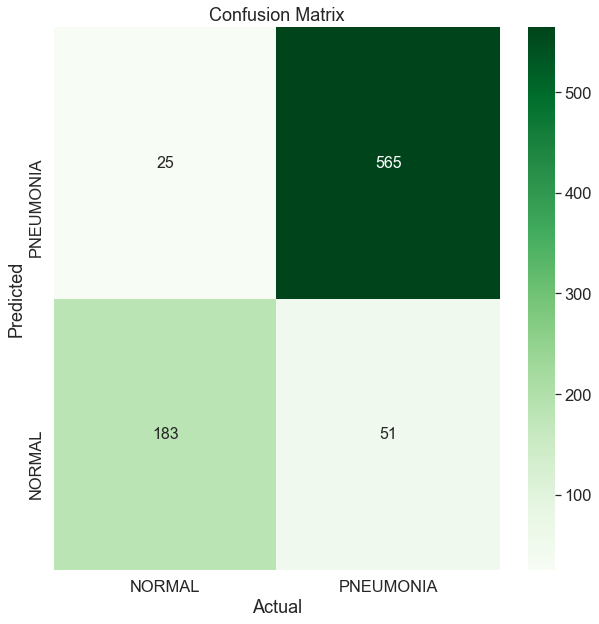

In [9]:
predictions_test = (model_for_export.predict(test_gen,verbose=True) > 0.5).astype("int32")
from sklearn.metrics import classification_report,confusion_matrix
y_true = np.array([0] * 234 + [1] * 590) #234 Normal, #590 Pneumonia
data = confusion_matrix(y_true, predictions_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Predicted'
df_cm.columns.name = 'Actual'
plt.figure(figsize = (10,10))
sns.set(font_scale=1.5)
ax = sns.heatmap(df_cm,cmap = 'Greens', annot=True,fmt = '.5g',annot_kws={"size": 16})# font size
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']);
ax.set_ylim([0,2])

print("Classification Report: ")
print(classification_report(y_true,predictions_test))

In [10]:
model_for_export.save('first_model_pruned.h5')